# Imports

## Packages

In [158]:
import pandas as pd
import fbprophet
from fbprophet import Prophet
from dateutil.easter import easter

In [324]:
%matplotlib inline 
import numpy as np
import matplotlib.pylab as plt
import datetime
import seaborn as sns
import statsmodels.api as sm
import glob 
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR,ARResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams
from pmdarima import auto_arima 
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import math

In [2]:
# pip install fbprophet

import pystan
model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
model = pystan.StanModel(model_code=model_code)  # this will take a minute
y = model.sampling(n_jobs=1).extract()['y']
y.mean()  # should be close to 0

In [4]:
# https://github.com/facebook/prophet/issues/1300
## for the command pip install holidays==0.9.12

## Data

## File Imports

To use this notebook, download the files from https://nswtollroaddata.com under "Data Downloads" for "M1 Eastern Distibutor (ED)." Select the years 2016, 2017, 2018, 2019, 2020 separately and download each of the CSVs separately. Put them all in a folder and DO NOT include this folder name in user_directory.

In [14]:
#get user directory
user_directory = None

In [142]:
# function to get all of the files
def get_all_dataframes(path_to_data_folder):
    # give the path and this function will return all of the dataframes in a sorted list 
    original_data = glob.glob(path_to_data_folder + "/*/*/*csv",recursive=True)
    test_dataframe_list = []
    training_dataframe_list = []
    for item in original_data:
        with open(item) as f:
            df = pd.read_csv(f, parse_dates=[['Date', 'IntervalStart']], index_col = 'Date_IntervalStart')
            if "2020" in str(f):
                test_dataframe_list.append(df)
            else:
                training_dataframe_list.append(df)
    return test_dataframe_list, training_dataframe_list

In [143]:
# import files 
if user_directory != None:    #i.e.: use the directory given
    test_df_list, train_df_list = get_all_dataframes(user_directory)
else:    # point to my directory
    test_df_list, train_df_list = get_all_dataframes("./eastern_distrib")

In [144]:
len(train_df_list)

48

In [145]:
len(test_df_list)

6

In [146]:
train_df_list[0].head(2)

,AssetID,FinancialQtrID,IntervalEnd,Version,VehicleClass,TollPointID,GantryDirection,GantryLocation,GantryGPSLatitude,GantryGPSLongitude,GantryType,TotalVolume
Date_IntervalStart,,,,,,,,,,,,
2015-12-01,ED,201602,00:14,1,Car,C,N,William Street North-bound exit ramp,-33.875924,151.217253,Ramp Gantry,6
2015-12-01,ED,201602,00:14,1,Car,AB,N,Woolloomooloo Toll Plaza North-bound,-33.869714,151.218398,Mainline Gantry,19


In [148]:
test_df_list[0].head(2)

,AssetID,FinancialQtrID,IntervalEnd,Version,VehicleClass,TollPointID,GantryDirection,GantryLocation,GantryGPSLatitude,GantryGPSLongitude,GantryType,TotalVolume
Date_IntervalStart,,,,,,,,,,,,
2019-12-01,ED,202002,00:14,1,Car,AB,N,Woolloomooloo Toll Plaza North-bound,-33.869714,151.218398,Mainline Gantry,161
2019-12-01,ED,202002,00:14,1,Truck,AB,N,Woolloomooloo Toll Plaza North-bound,-33.869714,151.218398,Mainline Gantry,2


# Cleaning the Dataframe

In [149]:
# function to clean the dataframe list 
def clean_dfs(dataframe_list):
    clean_dataframe_list = []
    for df in dataframe_list:
        df_C = df[df['TollPointID'] == 'C']
        df_grouped = pd.DataFrame(df_C.groupby('Date_IntervalStart').TotalVolume.sum())
        clean_dataframe_list.append(df_grouped)
    return clean_dataframe_list

In [150]:
# training dataframes
clean_train_df_list = clean_dfs(train_df_list)
# test dataframes
clean_test_df_list = clean_dfs(test_df_list)

In [151]:
clean_train_df_list[0].head(2)

,TotalVolume
Date_IntervalStart,
2015-12-01 00:00:00,6
2015-12-01 00:15:00,5


## Combing the list dataframes into one dataframe 

In [235]:
train_df = pd.concat(clean_train_df_list)
test_df = pd.concat(clean_test_df_list)

In [236]:
train_df.head(2)

,TotalVolume
Date_IntervalStart,
2015-12-01 00:00:00,6
2015-12-01 00:15:00,5


### Making test_df hourly

In [337]:
test_df_hourly = test_df.resample('h').sum()

In [338]:
test_df_hourly.head(2)

,TotalVolume
Date_IntervalStart,
2019-07-01 00:00:00,29
2019-07-01 01:00:00,15


In [361]:
test_df_hourly.reset_index(inplace=True)

# Using fbprophet

## Putting df in the format it requires

In [237]:
fb_prophet_train_df = train_df.reset_index()

In [238]:
fb_prophet_train_df.columns = ['ds', 'y']

In [239]:
fb_prophet_train_df.columns

Index(['ds', 'y'], dtype='object')

In [242]:
fb_prophet_train_df['ds'][1:10]

1   2015-12-01 00:15:00
2   2015-12-01 00:30:00
3   2015-12-01 00:45:00
4   2015-12-01 01:00:00
5   2015-12-01 01:15:00
6   2015-12-01 01:30:00
7   2015-12-01 01:45:00
8   2015-12-01 02:00:00
9   2015-12-01 02:15:00
Name: ds, dtype: datetime64[ns]

In [270]:
type(fb_prophet_train_df['ds'][0])

pandas._libs.tslibs.timestamps.Timestamp

### Changing type of values in ds

In [341]:
# actual_datetime = fb_prophet_train_df['ds'][0].strftime('%Y-%m-%d-%H-%M')

In [255]:
datetimes_str = [x.strftime('%Y-%m-%d %H:%M') for x in fb_prophet_train_df['ds']]

### First Model

In [193]:
# not sure what type the ds column should be 
## maybe it should be in datetime format, not pandas version of that 
fb_prophet_train_df['ds'] = fb_prophet_train_df['ds'].values.astype('<M8[D]')

In [220]:
prophetfmodel = Prophet(daily_seasonality=True)

In [221]:
prophetfmodel.fit(fb_prophet_train_df)

In [342]:
one_week = 24 * 4
test_df_length = len(test_df_hourly)

In [343]:
future = prophetfmodel.make_future_dataframe(periods=test_df_length, freq='H')
future.tail()

,ds
143252,2019-12-30 20:00:00
143253,2019-12-30 21:00:00
143254,2019-12-30 22:00:00
143255,2019-12-30 23:00:00
143256,2019-12-31 00:00:00


In [344]:
forecast = prophetfmodel.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
143252,2019-12-30 20:00:00,-12.070432,-134.256660,104.052104
143253,2019-12-30 21:00:00,0.197393,-120.819051,127.749343
143254,2019-12-30 22:00:00,46.166990,-70.038903,168.792805
143255,2019-12-30 23:00:00,99.710881,-16.250930,218.722918
143256,2019-12-31 00:00:00,123.348036,8.233784,243.991444


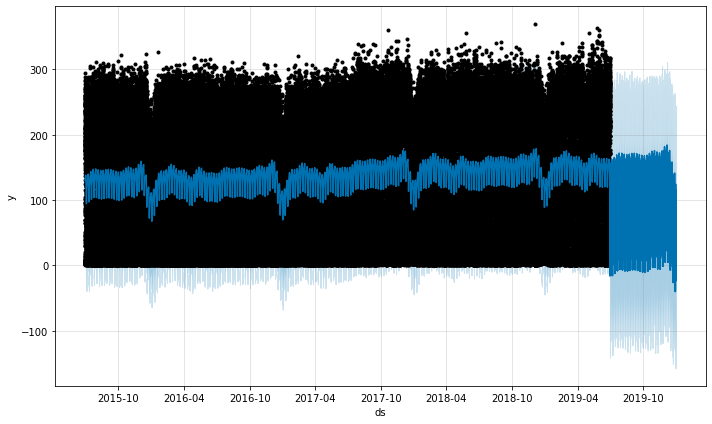

In [345]:
fig1 = prophetfmodel.plot(forecast)

### Model 2

#### New df to work with 

In [258]:
new_train_df = fb_prophet_train_df.copy()

In [259]:
new_train_df['ds'] = datetimes_str

In [260]:
new_train_df.head(2)

,ds,y
0,2015-12-01 00:00,6
1,2015-12-01 00:15,5


In [251]:
type(actual_datetime)

str

#### Resampling to hour 

In [271]:
daily_train_df = fb_prophet_train_df.set_index('ds')

In [273]:
daily_train_df.head(2)

,y
ds,
2015-12-01 00:00:00,6
2015-12-01 00:15:00,5


In [274]:
train_df_days = daily_train_df.resample('h').sum()

In [275]:
train_df_days.head(2)

,y
ds,
2015-07-01 00:00:00,19
2015-07-01 01:00:00,16


In [276]:
train_df_days.reset_index(inplace=True)

#### Model 2

In [289]:
prophetfmodel2 = Prophet(daily_seasonality=True, yearly_seasonality = True, weekly_seasonality = True)

In [290]:
prophetfmodel2.fit(train_df_days)

In [346]:
six_month = (24 * 7)
test_df_length = len(test_df_hourly)

In [347]:
# I can only do hourly or minute frequencies... https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future2 = prophetfmodel2.make_future_dataframe(periods=test_df_length, freq='H')
future2.tail()

,ds
39475,2019-12-31 19:00:00
39476,2019-12-31 20:00:00
39477,2019-12-31 21:00:00
39478,2019-12-31 22:00:00
39479,2019-12-31 23:00:00


In [348]:
forecast2 = prophetfmodel2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
39475,2019-12-31 19:00:00,653.026612,470.233206,831.369339
39476,2019-12-31 20:00:00,439.865587,255.636289,618.763620
39477,2019-12-31 21:00:00,250.376351,85.495922,442.897733
39478,2019-12-31 22:00:00,141.488202,-38.072101,321.714294
39479,2019-12-31 23:00:00,99.260786,-72.398799,286.548592


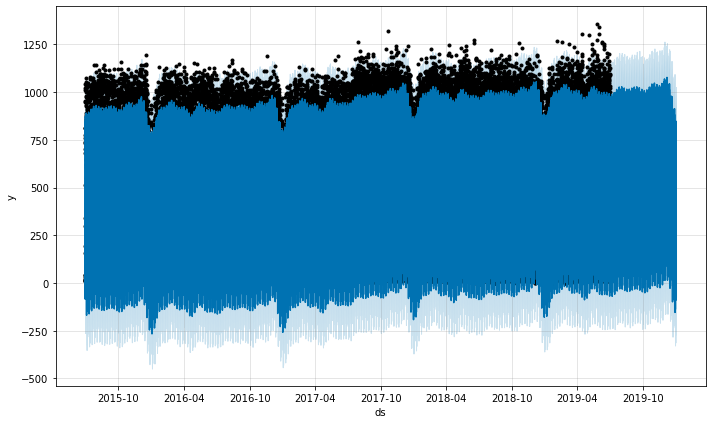

In [349]:
fig2 = prophetfmodel2.plot(forecast2)

### Model With Cap and Min
https://facebook.github.io/prophet/docs/saturating_forecasts.html

In [306]:
train_df_days2 = train_df_days.copy()

In [307]:
train_df_days2['cap'] = 1400
train_df_days2['floor'] = 0

In [308]:
prophetfmodel3 = Prophet(growth='logistic', daily_seasonality=True, yearly_seasonality = True, weekly_seasonality = True)

In [309]:
prophetfmodel3.fit(train_df_days2)

In [350]:
one_week = 24 * 7
test_df_length = len(test_df_hourly)

In [351]:
# I can only do hourly or minute frequencies... https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future3 = prophetfmodel3.make_future_dataframe(periods=test_df_length, freq='H')
future3.tail(2)
future3['floor'] = 0
future3['cap'] = 1400

In [352]:
# basically same predictions as before 
forecast3 = prophetfmodel3.predict(future3)
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
39475,2019-12-31 19:00:00,649.074415,466.541892,837.848200
39476,2019-12-31 20:00:00,435.912466,270.074076,622.325502
39477,2019-12-31 21:00:00,246.422386,64.111462,406.390143
39478,2019-12-31 22:00:00,137.533661,-43.237795,315.433467
39479,2019-12-31 23:00:00,95.305980,-97.885474,271.470005


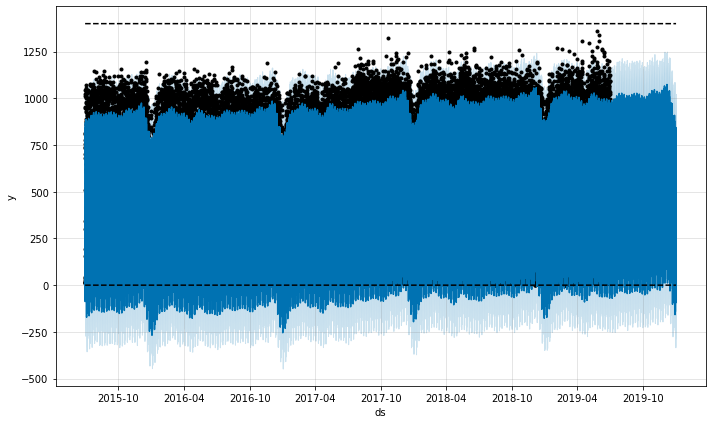

In [353]:
fig3 = prophetfmodel3.plot(forecast3)

## Evaluating Models

In [ ]:
#RMSE 

In [ ]:
# model 1: incorrect time frequency (predicts hour when given 15 mins)
# model 2: linear 
# model 3: logistic 

In [387]:
test_df_length

4416

In [402]:
# these models do WAAAY better over the long term
labels = ['Model1_15mins', 'Model2_lin', 'Model3_log']
preds_list = [forecast[['yhat']][138864:], 
             forecast2[['yhat']][-test_df_length:-23],
             forecast3[['yhat']][-test_df_length:-23]]

for i in range(len(preds_list)):
    error = mean_squared_error(test_df_hourly['TotalVolume'].iloc[-test_df_length:-23], preds_list[i])
    print(f'{labels[i]} Error: {error:11.10}')

Model1_15mins Error: 488723.5655
Model2_lin Error: 22882.04218
Model3_log Error: 22903.96932


In [418]:
""" From our previous "Sydney_traffic" notebook
AR Error: 4111716.462
SARIMAX Error: 1517624.712"""

'AR Error: 4111716.462\nSARIMAX Error: 1517624.712'

### over 3 week period

In [390]:
three_weeks = 24*21

In [420]:
forecast[['ds','yhat']][138864:-three_weeks]

,ds,yhat
138864,2019-07-01 00:00:00,140.359702
138865,2019-07-01 01:00:00,117.660292
138866,2019-07-01 02:00:00,64.991318
138867,2019-07-01 03:00:00,19.835278
138868,2019-07-01 04:00:00,8.322224
...,...,...
142748,2019-12-09 20:00:00,32.190157
142749,2019-12-09 21:00:00,44.427922
142750,2019-12-09 22:00:00,90.366467
142751,2019-12-09 23:00:00,143.878316


In [414]:
# forecast2[['ds','yhat']][-test_df_length:-(three_weeks+23)]

In [417]:
# forecast3[['yhat']][-test_df_length:-(three_weeks+23)]

In [423]:
test_df_hourly[:3889]

,Date_IntervalStart,TotalVolume
0,2019-07-01 00:00:00,29
1,2019-07-01 01:00:00,15
2,2019-07-01 02:00:00,20
3,2019-07-01 03:00:00,22
4,2019-07-01 04:00:00,78
...,...,...
3884,2019-12-09 20:00:00,545
3885,2019-12-09 21:00:00,384
3886,2019-12-09 22:00:00,209
3887,2019-12-09 23:00:00,114


In [425]:
# fbprophet models do waaaaay better 
preds_list2 = [forecast[['yhat']][138864:-three_weeks], 
             forecast2[['yhat']][-test_df_length:-(three_weeks+23)],
             forecast3[['yhat']][-test_df_length:-(three_weeks+23)]]

for i in range(len(preds_list2)):
    error = mean_squared_error(test_df_hourly['TotalVolume'][:3889], preds_list2[i])
    print(f'{labels[i]} Error: {error:11.10}')

Model1_15mins Error:  494270.201
Model2_lin Error: 22331.86082
Model3_log Error: 22347.41057


In [409]:
""" From our previous "Sydney_traffic" notebook
ARnolag Error: 68322.47476
AR Error:   58524.534
ARMA Error: 144629.2036
SARIMAX Error: 150113.7128
SARIMAX_SEASONAL Error: 150113.7128"""

'ARnolag Error: 68322.47476\nAR Error:   58524.534\nARMA Error: 144629.2036\nSARIMAX Error: 150113.7128\nSARIMAX_SEASONAL Error: 150113.7128'

### Removing any negative yhat values

In [ ]:
# am I allowed to do this? We know beforehand that there can't be a negative amount of drivers on the road...